In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


   # of stores  train_dev_sample_and_batch_size      Architecture Class  n_stores  Train Loss  Dev Loss  Test Loss  Test Gap %                                                                                                                                                                                                                                                                             path
0            3                              128        vanilla_n_stores         3    6.495986  6.506594   6.618114    0.769781        /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/run_2025-04-20_11-55-03/run_d27ff_00377_377_config=n_stores_lost_demand_fixed,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.00_2025-04-21_11-48-18
0            3                              128     n_stores_shared_net         3    6.520233  6.472880   6.572039    0.068214     /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_f

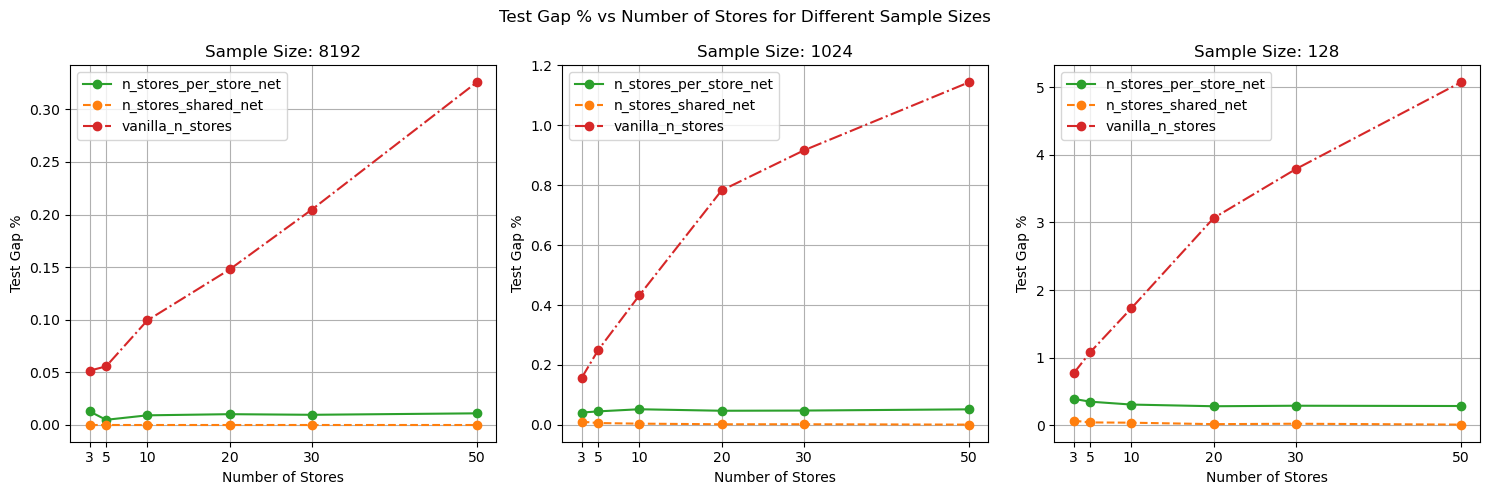

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "n_stores_per_store_net": "#2ca02c",  # Green
    "n_stores_shared_net": "#ff7f0e",  # Orange
    "vanilla_n_stores": "#d62728"  # Red
}

linestyle_scheme = {
    "n_stores_per_store_net": "-",  # Solid
    "n_stores_shared_net": "--",  # Dashed 
    "vanilla_n_stores": "-."  # Dash-dot
}

testset_name = "models_overfit_in_many_stores_test_fixed"

# Define architectures with their path patterns
architectures = {
    "vanilla_n_stores": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores',
    "n_stores_shared_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net',
    "n_stores_per_store_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_per_store_net'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [8192, 1024, 128]

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

results_interpretor = rri.RayResultsinterpreter()

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for n_store in n_stores:
        path = path_fn(n_store)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes, 'n_stores': n_store},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        if not df.empty:
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['n_stores'] = n_store
            df['# of stores'] = n_store
            dfs.append(df)
df = pd.concat(dfs)

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create plot grid for different sample sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Test Gap % vs Number of Stores for Different Sample Sizes')

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle=linestyle_scheme[column])
    
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Test Gap %')
    ax.set_title(f'Sample Size: {sample_size}')
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    ax.legend()  # Show legend on each subplot

plt.tight_layout()
plt.show()

In [5]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,Test Gap %,n_stores
0,1,vanilla_n_stores,8192,vanilla_n_stores,0.001,6.565838,6.572148,6.574864,34,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.163355,3
0,1,vanilla_n_stores,8192,vanilla_n_stores,0.001,6.565838,6.572148,6.574864,34,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.163355,5
0,1,vanilla_n_stores,8192,vanilla_n_stores,0.001,6.565838,6.572148,6.574864,34,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.163355,10
0,1,vanilla_n_stores,8192,vanilla_n_stores,0.001,6.565838,6.572148,6.574864,34,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.163355,20
0,1,vanilla_n_stores,8192,vanilla_n_stores,0.001,6.565838,6.572148,6.574864,34,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.163355,30
0,1,vanilla_n_stores,8192,vanilla_n_stores,0.001,6.565838,6.572148,6.574864,34,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.163355,50
0,1,n_stores_shared_net,8192,n_stores_shared_net,0.001,6.564969,6.558754,6.564141,10,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.000000,3
0,1,n_stores_shared_net,8192,n_stores_shared_net,0.001,6.564969,6.558754,6.564141,10,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.000000,5
0,1,n_stores_shared_net,8192,n_stores_shared_net,0.001,6.564969,6.558754,6.564141,10,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.000000,10
0,1,n_stores_shared_net,8192,n_stores_shared_net,0.001,6.564969,6.558754,6.564141,10,/user/ml4723/Prj/NIC/ray_results/models_overfi...,0.000000,20
